## General information

In this kernel I'm working with data from TMDB Box Office Prediction Challenge. Film industry is booming, the revunues are growing, so we have a lot of data about films. Can we build models, which will be able to accurately predict film revenues? Could this models be used to make some changes in movies to increase their revenues even further? I'll try answer this questions in my kernel!

![](https://i.imgur.com/KVb5zO7.jpg)
*(Screenshot of the main page of https://www.themoviedb.org/)*

## Content

* [1 Data loading and overview](#data_loading)
* [1.1 belongs_to_collection](#btoc)
* [1.2 genres](#genres)
* [1.3 Production companies](#production_companies)
* [1.4 Production countries](#production_countries)
* [1.5 Spoken languages](#lang)
* [1.6 Keywords](#keywords)
* [1.7 Cast](#cast)
* [1.8 Crew](#crew)
* [2 Data exploration](#de)
* [2.1 Target](#target)
* [2.2 Budget](#budget)
* [2.3 Homepage](#homepage)
* [2.4 Original language](#or_lang)
* [2.5 Original title](#or_title)
* [2.6 Overview](#overview)
* [2.7 Popularity](#popularity)
* [2.8 Release date](#release_date)
* [2.9 Runtime](#runtime)
* [2.10 Status](#status)
* [2.11 Tagline](#tagline)
* [2.12 Collections](#collections)
* [2.13 Genres](#genres_)
* [2.14 Production companies](#prod_comp)
* [2.15 Production countries](#prod_count)
* [2.16 Cast](#cast_viz)
* [2.17 Keywords](#key_viz)
* [2.18 Crew](#crew_viz)
* [3 Modelling and feature generation](#basic_model)
* [3.1 OOF features based on texts](#oof)
* [3.2 Additional feature generation](#add_feat)
* [3.3 Important features](#imp_feats)
* [3.4 External features](#ext_feats)
* [3.5 Blending](#blending)
* [3.6 Stacking](#stacking)

In [63]:
# Libraries

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
# import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
# stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
# import xgboost as xgb
# import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
# import eli5
# import shap
# from catboost import CatBoostRegressor
from urllib.request import urlopen

from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

<a id="data_loading"></a>
## Data loading and overview

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

In [3]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
train.shape, test.shape

((3000, 23), (4398, 22))

There are only 3000 samples in train data! Let's hope this is enough to train models.

We can see that some of columns contain lists with dictionaries. Some lists contain a single dictionary, some have several. Let's extract data from these columns!

<a id="btoc"></a>
### belongs_to_collection

In [5]:
for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [6]:
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

2396 values in this column are empty, 604 contrain information about the collections. I suppose that only collection name can be useful. Another possibly useful feature is the fact of belonging to a collection.

In [7]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

In [8]:
train.head()

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,0
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0,0


<a id="genres"></a>
### genres

In [9]:
for i, e in enumerate(train['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [10]:
print('Number of genres in films')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

Genres column contains named and ids of genres to which films belong. Most of films have 2-3 genres and 5-6 genres are possible. 0 and 7 are outliers, I think. Let's extract genres! I'll create a column with all genres in the film and also separate columns for each genre.

But at first let's have a look at the genres themselves.

In [11]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

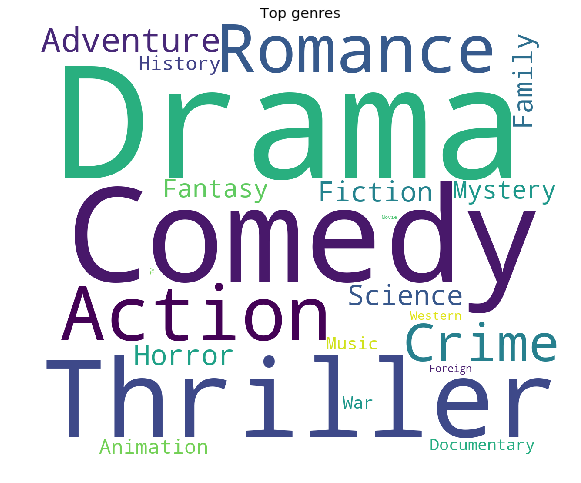

In [12]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

Drama, Comedy and Thriller are popular genres.

In [13]:
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

I'll create separate columns for top-15 genres.

In [14]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

<a id="production_companies"></a>
### production_companies

In [15]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [16]:
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

Most of films have 1-2 production companies, cometimes 3-4. But there are films with 10+ companies! Let's have a look at some of them.

In [17]:
train[train['production_companies'].apply(lambda x: len(x) if x != {} else 0) > 11]

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music
31,32,0,http://www.cache-derfilm.at,tt0387898,fr,Caché,A married couple is terrorized by a series of ...,5.695860,/i1Zl8S4DgM3IDLW5dhZzBnIdCOe.jpg,"[{'name': 'Les Films du Losange', 'id': 223}, ...","[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...",5/2/05,117.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Caché,"[{'id': 90, 'name': 'paris'}, {'id': 213, 'nam...","[{'cast_id': 2, 'character': 'Georges Laurent'...","[{'credit_id': '52fe4244c3a36847f8011073', 'de...",36000000,0,0,3,Drama Mystery Thriller,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
116,117,0,NaN,tt2113822,zh,一九四二,"In 1942, Henan Province was devastated by the ...",1.678013,/xxz2gi8vijqqJySGO3kQy2i8mv.jpg,"[{'name': 'Emperor Motion Pictures', 'id': 272...","[{'iso_3166_1': 'CN', 'name': 'China'}]",11/1/12,145.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Back to 1942,"[{'id': 478, 'name': 'china'}, {'id': 180999, ...","[{'cast_id': 3, 'character': 'Theodore Harold ...","[{'credit_id': '5761375dc3a36808aa001554', 'de...",311,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
363,364,15400000,NaN,tt2053425,fr,De rouille et d'os,"Put in charge of his young son, Ali leaves Bel...",8.400049,/cHCwW8xPl8yPKQwpNzKVinwvirT.jpg,"[{'name': 'France 2 Cinéma', 'id': 83}, {'name...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",5/17/12,123.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Rust and Bone,"[{'id': 494, 'name': 'father son relationship'...","[{'cast_id': 2, 'character': 'St√©phanie', 'cr...","[{'credit_id': '52fe49dd9251416c750d5e05', 'de...",25762027,0,0,2,Drama Romance,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
392,393,0,NaN,tt5072406,fr,Moka,Diane Kramer is led by one obsession: to find ...,2.404466,/5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg,"[{'name': 'Canal+', 'id': 5358}, {'name': 'Cin...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/17/16,89.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Moka,{},"[{'cast_id': 1, 'character': 'Diane', 'credit_...","[{'credit_id': '59619ddd9251410bfa0cf8e5', 'de...",126463,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
449,450,80000000,http://asoundofthunder.warnerbros.com/,tt0318081,en,A Sound of Thunder,When a hunter sent back to the prehistoric era...,4.980191,/gsqOX1ReJ5lcmTuDdkhOXLug8Ug.jpg,"[{'name': 'Epsilon Motion Pictures', 'id': 117...","[{'iso_3166_1': 'CZ', 'name': 'Czech Republic'...",5/15/05,110.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Some Rules Should Never Be Broken.,A Sound of Thunder,"[{'id': 3737, 'name': 'dying and death'}, {'id...","[{'cast_id': 34, 'character': 'Alicia Wallenbe...","[{'credit_id': '52fe431e9251416c7500438b', 'de...",5989640,0,0,4,Action Adventure Science Fiction Thriller,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0
554,555,14500000,NaN,tt0293416,ja,Metropolis,Duke Red has overseen the construction of a ma...,9.298092,/1EK7mGCpRKYmSg25FaojvnS9opm.jpg,"[{'name': 'Bandai Visual Company', 'id': 528},...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",5/26/01,108.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,Welcome to Metropolis,Metropolis,"[{'id': 931, 'name': 'jealousy'}, {'id': 1761,...","[{'cast_id': 1, 'character': 'Tima (voice)', '...","[{'credit_id': '52fe4510c3a36847f80ba41d', 'de...",95789342,0,0,2,Animation Science Fiction,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1079,1080,7000000,NaN,tt2737050,fr,"Deux jours, une nuit",Sandra is a young woman who has only one weeke...,6.868022,/1mYAejpMskvskGr0J0SaBvdjmrH.jpg,"[{'name': 'BIM Distribuzione', 'id': 225}, {'n...","[{'iso_

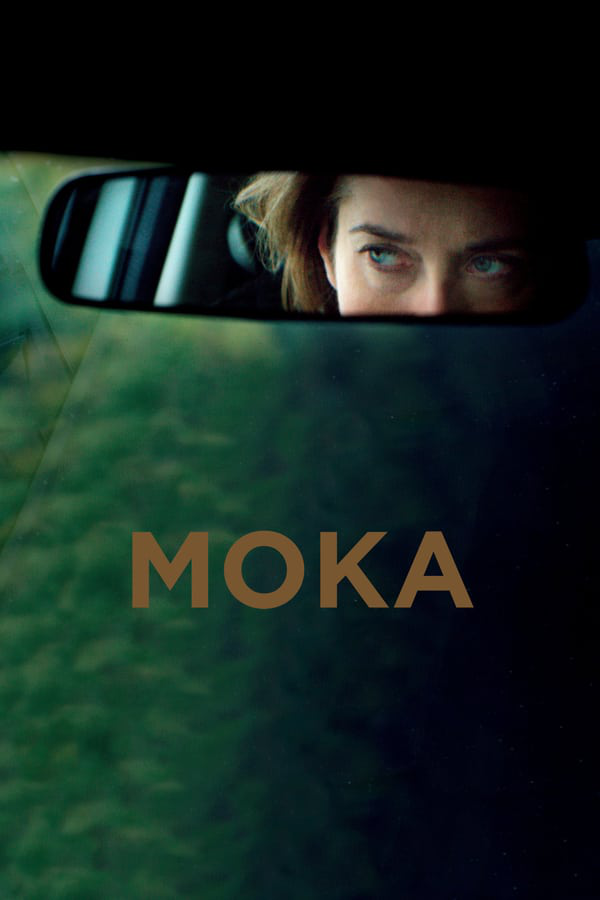

In [18]:
# example of poster of such a film

img = Image.open(urlopen("https://image.tmdb.org/t/p/w600_and_h900_bestv2/5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg"))
img

In [19]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [20]:
Counter([i for j in list_of_companies for i in j]).most_common(30)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23)]

For now I'm not sure what to do with this data. I'll simply create binary columns for top-30 films. Maybe later I'll have a better idea.

In [21]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

<a id="production_countries"></a>
### production_countries

In [22]:
for i, e in enumerate(train['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [23]:
print('Number of production countries in films')
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production countries in films


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

Normally films are produced by a single country, but there are cases when companies from several countries worked together.

In [24]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10)]

In [25]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

<a id="lang"></a>
### Spoken languages

In [26]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [27]:
print('Number of spoken languages in films')
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [28]:
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [29]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

<a id="keywords"></a>
### Keywords

In [30]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [31]:
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

Here we have some keywords describing films. Of course there can be a lot of them. Let's have a look at the most common ones.

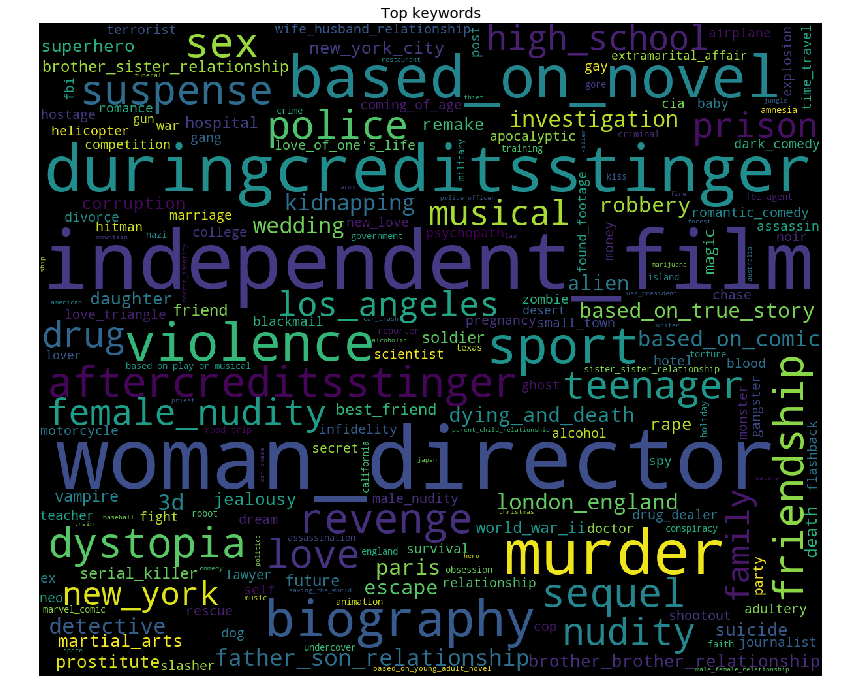

In [32]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

In [33]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

<a id="cast"></a>
### cast

In [34]:
for i, e in enumerate(train['cast'][:1]):
    print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [35]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

Those who are casted heavily impact the quality of the film. We have not only the name of the actor, but also the gender and character name/type.

At first let's have a look at the popular names.

In [36]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

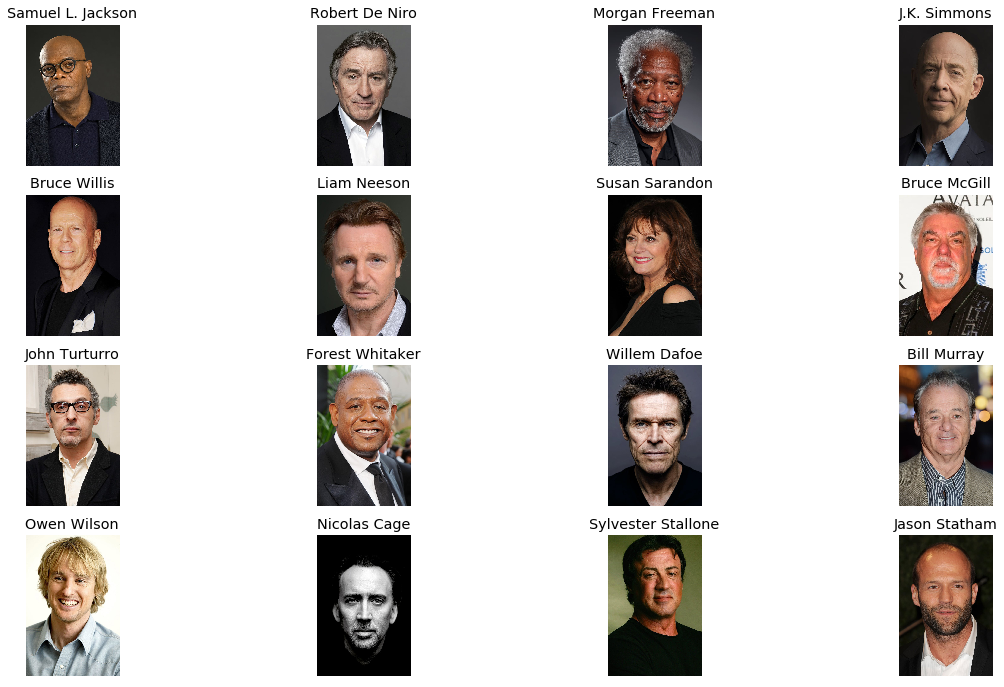

In [37]:
list_of_cast_names_url = list(train['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_cast_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 12))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
    plt.imshow(im)
    ax.set_title(f'{p[0]}')

In [38]:
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

[(2, 27949), (0, 20329), (1, 13533)]

0 is unspecified, 1 is female, and 2 is male. (https://www.kaggle.com/c/tmdb-box-office-prediction/discussion/80983#475572)

In [39]:
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

I think it is quite funny the most popular male role is playing himself. :)

In [40]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test['cast_name_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

<a id="crew"></a>
### crew

In [41]:
for i, e in enumerate(train['crew'][:1]):
    print(i, e[:10])

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [42]:
print('Number of casted persons in films')
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


2     179
11    127
10    126
3     126
12    110
9     109
8     109
14    104
4     101
7      94
Name: crew, dtype: int64

The great crew is very important in creating the film. We have not only the names of the crew members, but also the genders, jobs and departments.

At first let's have a look at the popular names.

In [43]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

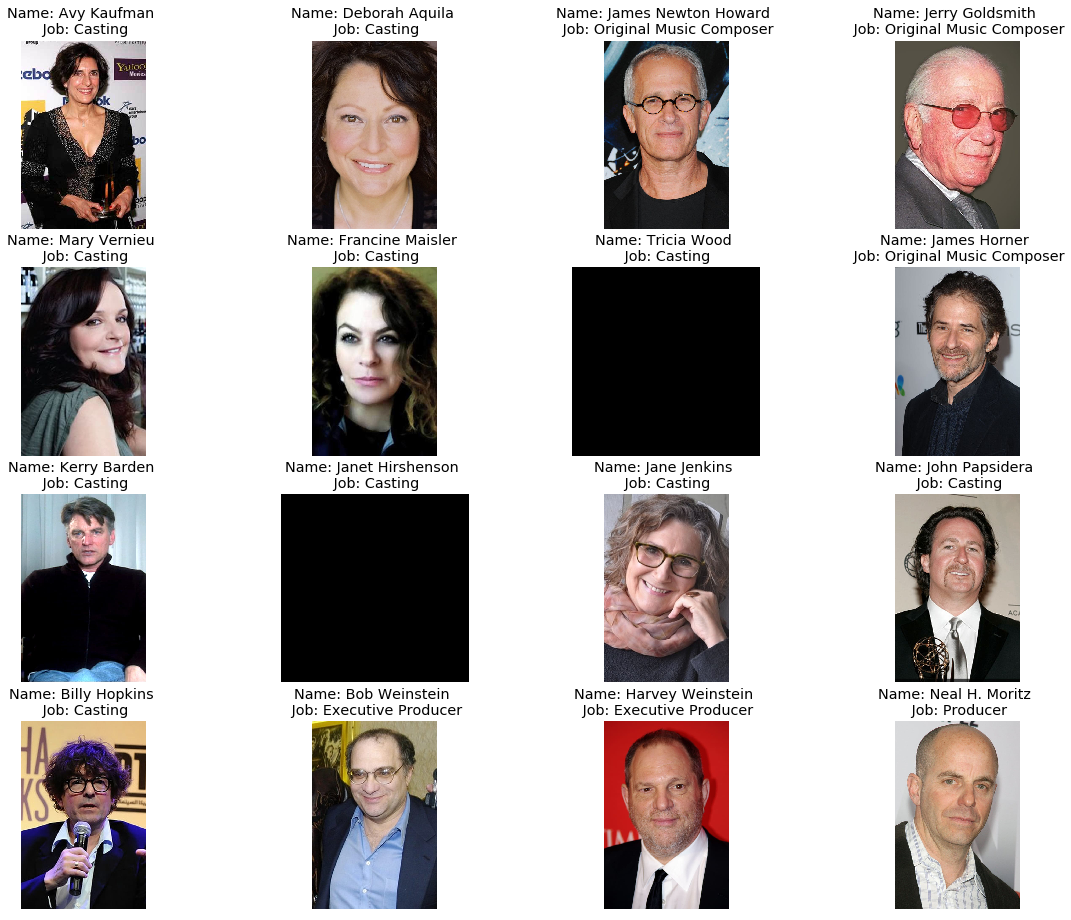

In [44]:
list_of_crew_names_url = list(train['crew'].apply(lambda x: [(i['name'], i['profile_path'], i['job']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_crew_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 16))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    if p[1]:
        im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
    else:
        im = Image.new('RGB', (5, 5))
    plt.imshow(im)
    ax.set_title(f'Name: {p[0]} \n Job: {p[2]}')

In [45]:
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

In [46]:
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 41787), (2, 24898), (1, 6412)]

In [47]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303),
 ('Actors', 4)]

In [48]:
list_of_crew_names = train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [49]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

<a id="de"></a>
## Data exploration

In [50]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_Keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,keyword_revenge,keyword_friendship,keyword_sex,keyword_suspense,keyword_sequel,keyword_love,keyword_police,keyword_teenager,keyword_nudity,keyword_female nudity,keyword_drug,keyword_prison,keyword_musical,keyword_high school,keyword_los angeles,keyword_new york,keyword_family,keyword_father son relationship,keyword_kidnapping,keyword_investigation,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_charac

<a id="target"></a>
### Target

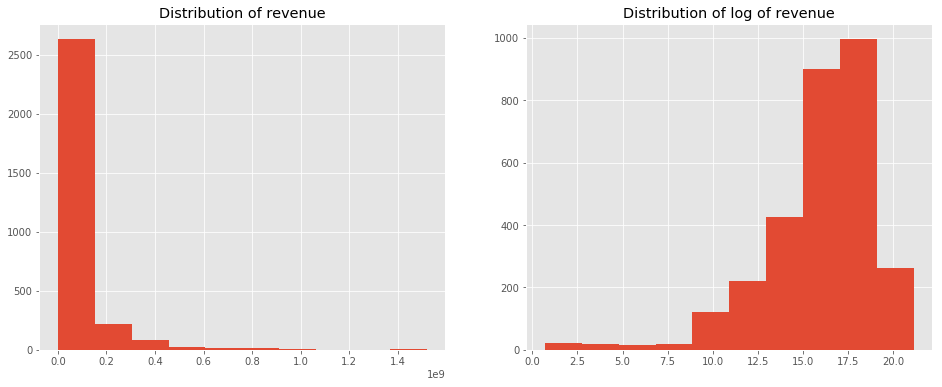

In [51]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

In [52]:
train['log_revenue'] = np.log1p(train['revenue'])

As we can see revenue distribution has a high skewness! It is better to use `np.log1p` of revenue.

<a id="budget"></a>
### Budget

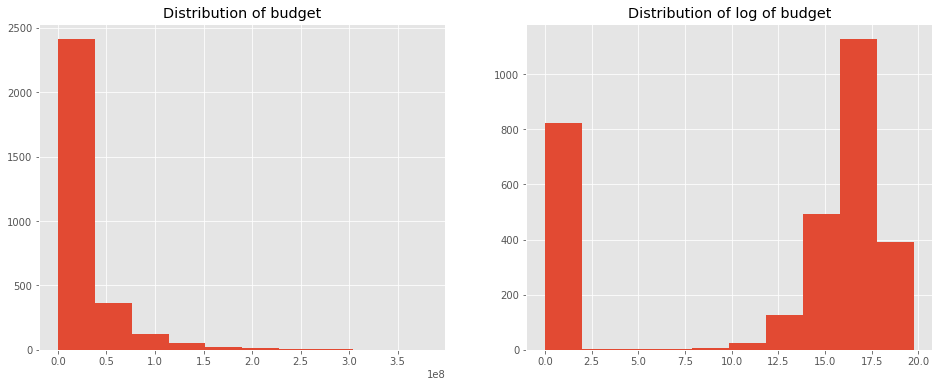

In [53]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

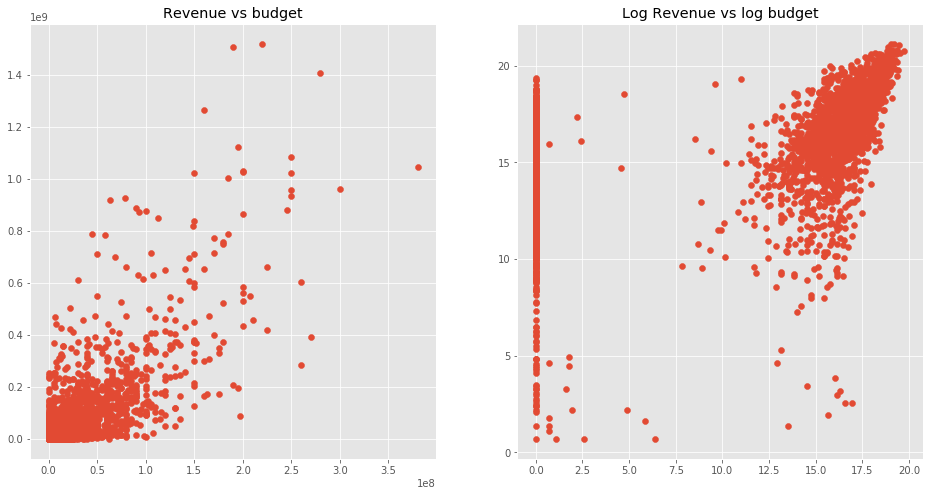

In [54]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget');

We can see that budget and revenue are somewhat correlated. Logarithm transformation makes budget distribution more managable.

In [55]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

<a id="homepage"></a>
### homepage

In [56]:
train['homepage'].value_counts().head()

http://www.transformersmovie.com/                           4
http://www.thehobbit.com/                                   2
http://www.lordoftherings.net/                              2
http://www.3l-filmverleih.de/rec                            1
http://disney.go.com/disneypictures/prom/index.html#home    1
Name: homepage, dtype: int64

Most of homepages are unique, so this feature may be useless.

In [57]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

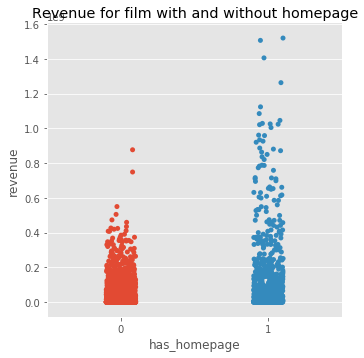

In [58]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for film with and without homepage');

Films with homepage tend to generate more revenue! I suppose people can know more about the film thanks to homepage.

<a id="or_lang"></a>
### original_language

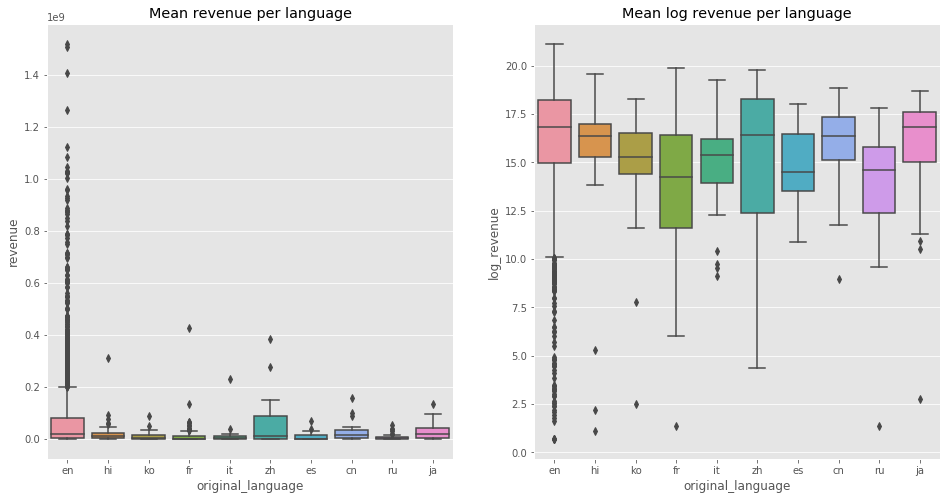

In [59]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

As we know there are much more english films and they have a higher range of values. Films with the highest revenue are usually in English, but there are also high revenue films in other languages.

<a id="or_title"></a>
### original_title

It can be interesting to see which words are common in titles.

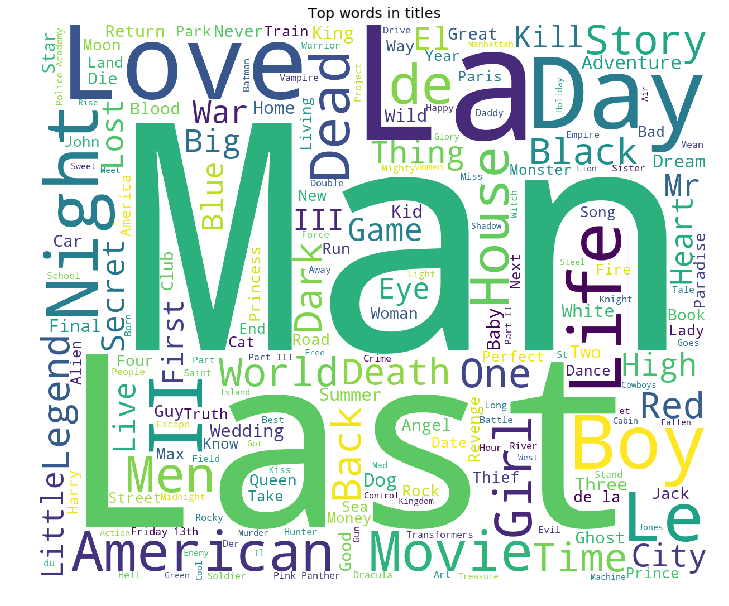

In [60]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

<a id="overview"></a>
### overview

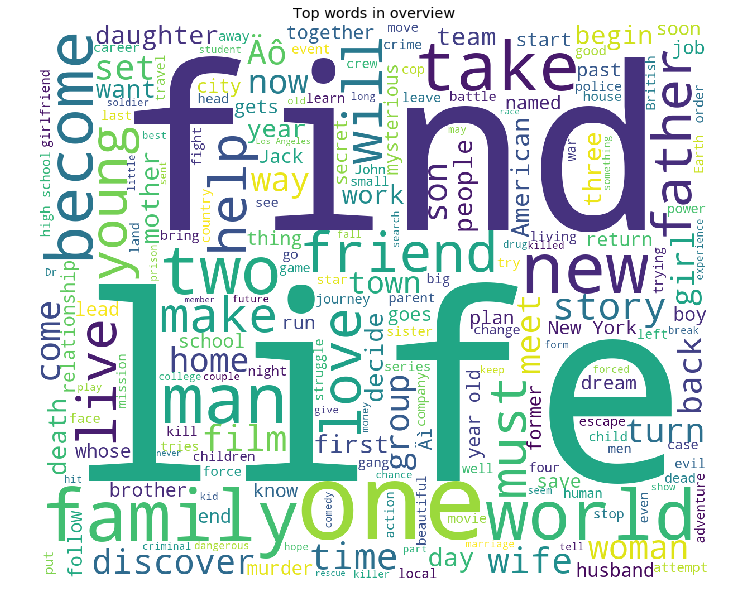

In [61]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

Let's try to see which words have high impact on the revenue. I'll build a simple model and use ELI5 for this.

In [62]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

NameError: name 'eli5' is not defined

In [ ]:
print('Target value:', train['log_revenue'][1000])
eli5.show_prediction(linreg, doc=train['overview'].values[1000], vec=vectorizer)

We can see that some words can be used to predict revenue, but we will need more that overview text to build a good model.

<a id="popularity"></a>
### popularity

I'm not exactly sure what does popularity represents. Maybe it is some king of weighted rating, maybe something else. It seems it has low correlation with the target.

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity');
plt.subplot(1, 2, 2)
plt.scatter(train['popularity'], train['log_revenue'])
plt.title('Log Revenue vs popularity');

<a id="release_data"></a>
### release_date

In [ ]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

In [ ]:
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [ ]:
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [ ]:
# creating features based on dates
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

train = process_date(train)
test = process_date(test)

In [ ]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [ ]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [ ]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

We can see that number of films and total revenue are growing, which is to be expected. But there were some years in the past with a high number of successful films, which brought high revenue.

In [ ]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

Surprisingly films releases on Wednesdays and on Thursdays tend to have a higher revenue.

<a id="runtime"></a>
### runtime

The length of the film in minutes

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity');

It seems that most of the films are 1.5-2 hour long and films with the highest revenue are also in this range

<a id="status"></a>
### Status

In [ ]:
train['status'].value_counts()

In [ ]:
test['status'].value_counts()

AS we can see only 4 films in train data and 7 in test aren't released yet, so this feature is quite useless.

<a id="tagline"></a>
### tagline

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

<a id="collections"></a>
### Collections

In [ ]:
sns.boxplot(x='has_collection', y='revenue', data=train);

Films, which are part of a collection usually have higher revenues. I suppose such films have a bigger fan base thanks to previous films.

<a id="genres_"></a>
### Genres

In [ ]:
sns.catplot(x='num_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');

In [ ]:
sns.violinplot(x='genre_Drama', y='revenue', data=train[:100]);

In [ ]:
f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

Some genres tend to have less revenue, some tend to have higher.

<a id="prod_comp"></a>
### Production companies

In [ ]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production company')
for i, e in enumerate([col for col in train.columns if 'production_company' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

There are only a couple of companies, which have distinctly higher revenues compared to others.

<a id="prod_count"></a>
### Production countries

In [ ]:
sns.catplot(x='num_countries', y='revenue', data=train);
plt.title('Revenue for different number of countries producing the film');

In fact I think that number of production countries hardly matters. Most films are produced by 1-2 companies, so films with 1-2 companies have the highest revenue.

In [ ]:
f, axes = plt.subplots(5, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in train.columns if 'production_country' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

There are only a couple of countries, which have distinctly higher revenues compared to others.

<a id="cast_viz"></a>
### Cast

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_cast'], train['revenue'])
plt.title('Number of cast members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_cast'], train['log_revenue'])
plt.title('Log Revenue vs number of cast members');

In [ ]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_name' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

In [ ]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

<a id="key_viz"></a>
### Keywords

In [ ]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs keyword')
for i, e in enumerate([col for col in train.columns if 'keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

<a id="crew_viz"></a>
### Crew

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_crew'], train['revenue'])
plt.title('Number of crew members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_crew'], train['log_revenue'])
plt.title('Log Revenue vs number of crew members');

In [ ]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs crew_character')
for i, e in enumerate([col for col in train.columns if 'crew_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

In [ ]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs jobs')
for i, e in enumerate([col for col in train.columns if 'jobs_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

<a id="basic_model"></a>
## Modelling and feature generation

In [ ]:
train = train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue'], axis=1)
test = test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

In [ ]:
for col in train.columns:
    if train[col].nunique() == 1:
        print(col)
        train = train.drop([col], axis=1)
        test = test.drop([col], axis=1)

In [ ]:
for col in ['original_language', 'collection_name', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))

In [ ]:
train_texts = train[['title', 'tagline', 'overview', 'original_title']]
test_texts = test[['title', 'tagline', 'overview', 'original_title']]

In [ ]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train = train.drop(col, axis=1)
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test = test.drop(col, axis=1)

In [ ]:
# data fixes from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

In [ ]:
X = train.drop(['id', 'revenue'], axis=1)
y = np.log1p(train['revenue'])
X_test = test.drop(['id'], axis=1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

In [ ]:
eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

In [ ]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [ ]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

<a id="oof"></a>
### OOF features based on texts

In [ ]:
for col in train_texts.columns:
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=10
    )
    vectorizer.fit(list(train_texts[col].fillna('')) + list(test_texts[col].fillna('')))
    train_col_text = vectorizer.transform(train_texts[col].fillna(''))
    test_col_text = vectorizer.transform(test_texts[col].fillna(''))
    model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
    oof_text, prediction_text = train_model(train_col_text, test_col_text, y, params=None, model_type='sklearn', model=model)
    
    X[col + '_oof'] = oof_text
    X_test[col + '_oof'] = prediction_text

<a id="add_feat"></a>
### Additional feature generation

In [ ]:
X.head()

In [ ]:
def new_features(df):
    df['budget_to_popularity'] = df['budget'] / df['popularity']
    df['budget_to_runtime'] = df['budget'] / df['runtime']
    
    # some features from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
    df['_budget_year_ratio'] = df['budget'] / (df['release_date_year'] * df['release_date_year'])
    df['_releaseYear_popularity_ratio'] = df['release_date_year'] / df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_date_year']
    
    df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_date_year")["runtime"].transform('mean')
    df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_date_year")["popularity"].transform('mean')
    df['budget_to_mean_year'] = df['budget'] / df.groupby("release_date_year")["budget"].transform('mean')
        
    return df

In [ ]:
X = new_features(X)
X_test = new_features(X_test)

In [ ]:
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

<a id="imp_feats"></a>
### Important features

Let's have a look at important features using ELI5 and SHAP!

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

We can see that important features native to LGB and top features in ELI5 are mostly similar. This means that our model is quite good at working with these features.

In [ ]:
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

SHAP provides more detailed information even if it may be more difficult to understand.

For example low budget has negavite impact on revenue, while high values usually tend to have higher revenue.

In [ ]:
top_cols = X_train.columns[np.argsort(shap_values.std(0))[::-1]][:10]
for col in top_cols:
    shap.dependence_plot(col, shap_values, X_train)

Here we can see interactions between important features. There are some interesting things here. For example relationship between release_date_year and log_budget. Up to ~1990 low budget films brought higher revenues, but after 2000 year high budgets tended to be correlated with higher revenues. And in genereal the effect of budget diminished.

Let's create new features as interactions between top important features. Some of them make little sense, but maybe they could improve the model.

In [ ]:
def top_cols_interaction(df):
    df['budget_to_year'] = df['budget'] / df['release_date_year']
    df['budget_to_mean_year_to_year'] = df['budget_to_mean_year'] / df['release_date_year']
    df['popularity_to_mean_year_to_log_budget'] = df['popularity_to_mean_year'] / df['log_budget']
    df['year_to_log_budget'] = df['release_date_year'] / df['log_budget']
    df['budget_to_runtime_to_year'] = df['budget_to_runtime'] / df['release_date_year']
    df['genders_1_cast_to_log_budget'] = df['genders_1_cast'] / df['log_budget']
    df['all_genres_to_popularity_to_mean_year'] = df['all_genres'] / df['popularity_to_mean_year']
    df['genders_2_crew_to_budget_to_mean_year'] = df['genders_2_crew'] / df['budget_to_mean_year']
    df['overview_oof_to_genders_2_crew'] = df['overview_oof'] / df['genders_2_crew']
    
    return df

In [ ]:
X = top_cols_interaction(X)
X_test = top_cols_interaction(X_test)

In [ ]:
X = X.replace([np.inf, -np.inf], 0).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

<a id="ext_feats"></a>
### External features
I'm adding external features from this kernel: https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat by kamalchhirang. All credit for these features goes to him and his kernel.

In [ ]:
trainAdditionalFeatures = pd.read_csv('../input/tmdb-competition-additional-features/TrainAdditionalFeatures.csv')
testAdditionalFeatures = pd.read_csv('../input/tmdb-competition-additional-features/TestAdditionalFeatures.csv')

train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
X['imdb_id'] = train['imdb_id']
X_test['imdb_id'] = test['imdb_id']
del train, test

X = pd.merge(X, trainAdditionalFeatures, how='left', on=['imdb_id'])
X_test = pd.merge(X_test, testAdditionalFeatures, how='left', on=['imdb_id'])

X = X.drop(['imdb_id'], axis=1)
X_test = X_test.drop(['imdb_id'], axis=1)

In [ ]:
X.head()

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

<a id="blending"></a>
### Blending

In [ ]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb, prediction_xgb = train_model(X, X_test, y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

In [ ]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat = train_model(X, X_test, y, params=cat_params, model_type='cat')

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, prediction_lgb_1 = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=False)

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2, prediction_lgb_2 = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=False)

<a id="stacking"></a>
### Stacking

In [ ]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_cat, prediction_lgb_1, prediction_lgb_2]).transpose()
test_stack = pd.DataFrame(test_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

In [ ]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 2,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack, prediction_lgb_stack, _ = train_model(train_stack, test_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

In [ ]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack, prediction_rcv_stack = train_model(train_stack.values, test_stack.values, y, params=None, model_type='sklearn', model=model)

In [ ]:
sub = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')
sub['revenue'] = np.expm1(prediction_lgb)
sub.to_csv("lgb.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb) / 2)
sub.to_csv("blend.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat) / 3)
sub.to_csv("blend1.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat + prediction_lgb_1) / 4)
sub.to_csv("blend2.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat + prediction_lgb_1 + prediction_lgb_2) / 5)
sub.to_csv("blend3.csv", index=False)

sub['revenue'] = prediction_lgb_stack
sub.to_csv("stack_lgb.csv", index=False)
sub['revenue'] = prediction_rcv_stack
sub.to_csv("stack_rcv.csv", index=False)
